In [11]:

import numpy as np
import math
import random
import imageio.v3 as iio\
    
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances
from scipy.ndimage import gaussian_filter

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax


Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


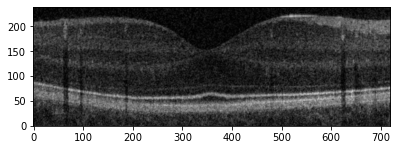

In [12]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)


In [13]:

class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

## MODIFIED COLOR FUNCTION
    def colour_at_t(self, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(np.linspace(0, 1, 100))).reshape(-1,2)))
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, image.shape[0]-1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, image.shape[1]-1)
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


    def point_at_t(self, image, points):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(np.linspace(0, 1, points))).reshape(-1,2)))
        return intermediates
    
##  CALCULATE PIXELS
    def covered_pixels_intensity(self, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(np.linspace(0, 1, 100))).reshape(-1, 2)))
        # Clip intermediate points to ensure they are within image bounds
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, image.shape[0]-1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, image.shape[1]-1)
        intensities = [image[point[0], point[1]] for point in intermediates]
        return np.array(intensities)

## GROUP DISTANCE(may needs modified)       
    def distance(self, worm2):
        return math.sqrt((self.x - worm2.x) ** 2 + (self.y - worm2.y) ** 2)

    def find_nearest_worms(self, worm_list, k=1):
        distances = []
        for worm in worm_list:
            if worm is not self:
                dist = self.distance(worm)
                distances.append((dist, worm))
        distances.sort()
        return [worm for _, worm in distances[:k]]


In [14]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots(figsize=(10,8)) ### Added figsize to ensure the plot is big enough to see in Jupyter notebook
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()

In [15]:

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew


##blurred image
def apply_gaussian_blur(image, sigma=1.0):
    blurred_image = gaussian_filter(image, sigma=sigma)
    return blurred_image

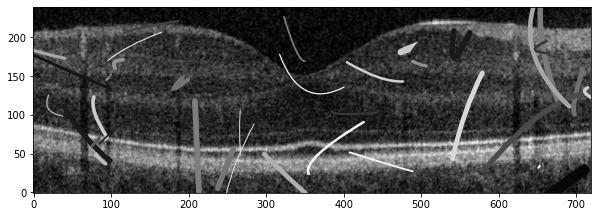

Worm 18: No covered pixels or intensity data available.
Worm 20: No covered pixels or intensity data available.
Min = 0's Count: 0


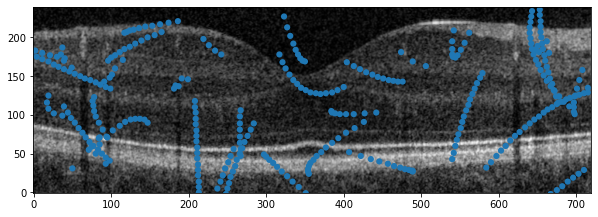

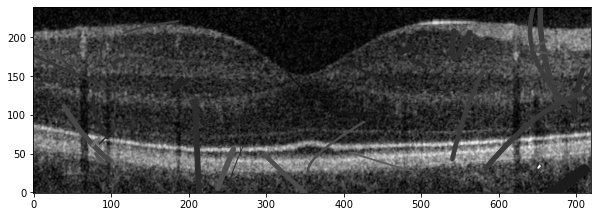

In [16]:
##  TEST DISPLAY ONLY

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()
count = 0
drawing_2 = Drawing(image)
for i, worm in enumerate(clew):
    curve_points = worm.point_at_t(image,int(worm.approx_length()/7))
    colours = []
    for n, point in enumerate(curve_points):
        if point[1] < 240 and point[0] < 720:
            drawing_2.add_dots([(point[0],point[1])])
            colour = apply_gaussian_blur(image, sigma=1.0)[point[1], point[0]]
            colours.append(colour/255)

    covered_intensities = np.array(colours)
    if covered_intensities.size > 0:
        max_intensity = np.max(covered_intensities)
        min_intensity = np.min(covered_intensities)
        avg_intensity = np.mean(covered_intensities)
#         print(f"Worm {i+1}:")
#         print("  - Maximum Intensity:", max_intensity)
#         print("  - Minimum Intensity:", min_intensity)
#         print("  - Average Intensity:", avg_intensity)
        if(min_intensity == 0):
            clew[i].clolour = 1 
            count += 1
        else:
            clew[i].colour = avg_intensity
    else:
        print(f"Worm {i+1}: No covered pixels or intensity data available.")
print("Min = 0's Count:", count)
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

In [17]:
def sample_colours_around_point_circle(image, point, width): #sampling by circle area
    
    x, y = int(point[0]), int(point[1])
    half_width = int(width // 2)
    sampled_colours = []

    
    for i in range(-half_width, half_width + 1):
        for j in range(-half_width, half_width + 1):
            new_x, new_y = x + i, y + j
            if 0 <= new_x < image.shape[1] and 0 <= new_y < image.shape[0]:
                sampled_colours.append(image[new_y, new_x])

    
    if sampled_colours:
        return np.mean(sampled_colours, axis=0) / 255
    else:
        return None

def sample_colours_at_diamond_points(image, point, width, layered=False, w0 = 2, w1 = 1.2): #sampling by vertex points
    x, y = int(point[0]), int(point[1])
    points_wide = [
        (x, int(y + (width*w0))),  
        (x, int(y - (width*w0))),  
        (int(x + (width*w0)), y),  
        (int(x - (width*w0)), y)   
    ]
    points = [
        (x, int(y + (width*w1))),  
        (x, int(y - (width*w1))),  
        (int(x + (width*w1)), y),  
        (int(x - (width*w1)), y)   
    ]
    sampled_colours_wide = 0
    sampled_colours_close = 0
    sampled_colours = []

    for px, py in points_wide:
        if 0 <= px < image.shape[1] and 0 <= py < image.shape[0]:
            sampled_colours_wide += image[py, px]
    for px, py in points:
        if 0 <= px < image.shape[1] and 0 <= py < image.shape[0]:
            sampled_colours.append(image[py, px])
            sampled_colours_close += image[py, px]
        
    if sampled_colours:
        if layered:
            return ((sampled_colours_wide + sampled_colours_close ) / 2) / 255
        else:
            return np.mean(sampled_colours, axis=0) / 255
    else:
        return None

In [18]:

def loss_function_init(worm, image, worms, w0 = 0.8, w1 = 0.2, w2 = 0.6):
    edge_loss = -4 * (sample_colours_at_diamond_points(image, (worm.x, worm.y), worm.width)**2) - 2 * sample_colours_at_diamond_points(image, (worm.x, worm.y), worm.width) 
    
    x_array = np.array([w.x for w in worms])
    y_array = np.array([w.y for w in worms])
    
    distances = np.sqrt((x_array - worm.x)**2 + (y_array - worm.y)**2)
    
    nearest_distances = np.partition(distances, 6)[:6]
    
    epsilon = 1e-10
    dist_cost = np.sum(1 / (nearest_distances + epsilon))

    width_cost = (1 / (worm.width)**2)
    
    total_loss = w0 * edge_loss + w1 * dist_cost + w2 * width_cost
    return total_loss

def loss_function(worm, image, worms, w1=0.3, w2=1, w3=0.2, w4=0.5, w5=0.7):
    num_worms = len(worms)
    colour_MSE = 0
    
    curve_points = worm.point_at_t(image, int(worm.approx_length()/6))
    colours = []
    for n, point in enumerate(curve_points):
        if point[1] < 240 and point[0] < 720:
            average_colour = sample_colours_around_point_circle(apply_gaussian_blur(image, sigma=1.0), point, worm.width)
            if average_colour is not None:
                colours.append(average_colour)
    avg_intensity = 0
    covered_intensities = np.array(colours)
    if len(covered_intensities) != 0:
        max_intensity = np.max(covered_intensities)
        min_intensity = np.min(covered_intensities)
        avg_intensity = np.mean(covered_intensities)
        error_max = max_intensity - avg_intensity
        error_min = min_intensity - avg_intensity
        squared_error_max = error_max ** 2
        squared_error_min = error_min ** 2
        colour_MSE = (squared_error_max + squared_error_min) / 2
    cover_loss = colour_MSE * (worm.width * 0.4)

    self_colour_loss = abs(avg_intensity - worm.colour)
    
    min_angle_diff = min(abs(worm.theta), abs(np.pi - worm.theta))
    horizontal_cost = 1 - np.cos(min_angle_diff)
    
    length_cost =  1 / worm.approx_length()

    width_cost = (1 / (worm.width)**2)

    total_distance = 0
    for other_worm in worms:
        distance = math.sqrt((worm.x - other_worm.x)**2 + (worm.y - other_worm.y)**2)
        total_distance += distance
    average_distance = total_distance / num_worms
    distance_cost = 1 / average_distance**2 if average_distance != 0 else float('inf')

    #print(f"horizontal_cost: {horizontal_cost}, length_cost: {length_cost}, width_cost: {width_cost}, colour_MSE: {cover_loss},  distance_cost: {distance_cost}")

    # total_loss = (w1 * horizontal_cost +
    #     w2 * length_cost +
    #     w3 * width_cost +
    #     w4 * cover_loss +
    #     w5 * distance_cost)
    total_loss = (w1 * horizontal_cost +
        w2 * length_cost +
        w3 * width_cost +
        w4 * cover_loss +
        w5 * self_colour_loss)
    
    return total_loss


In [19]:

def fixed_random_worm (x, y, init_params = (80,40,1)):
    (radius_std, deviation_std, width_theta) = init_params
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(x, y, r, theta, dr, dgamma, width, colour)


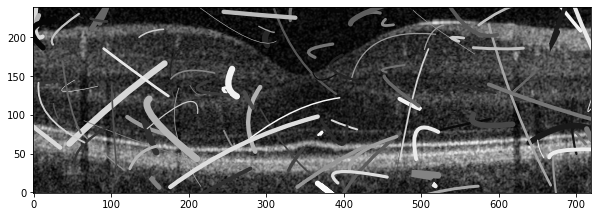

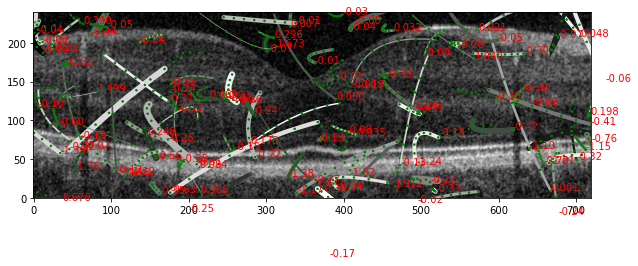

In [20]:
clew = initialise_clew(100, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)

drawing_5 = Drawing(image)
for i, worm in enumerate(clew):
    drawing_5.add_worms(worm)
    drawing_5.add_dots(worm.intermediate_points(8), radius=1, color='green')
    drawing_5.ax.text(worm.intermediate_points(1)[0][0], worm.intermediate_points(1)[0][1], str(loss_function_init(worm, image, new_clew))[0:5], color='red', fontsize=10)
drawing_5.show()

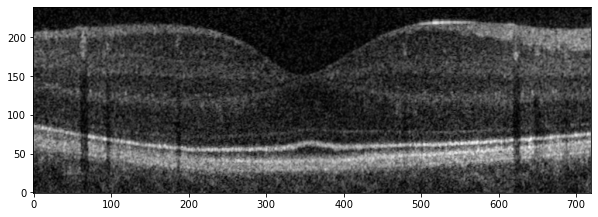

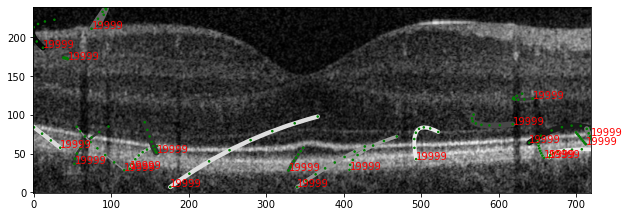

In [21]:
cost_arr = []
for worm in clew:
    cost_arr.append(loss_function_init(worm, image, clew))
cost_arr = np.array(cost_arr)
sorted_indices = np.argsort(cost_arr)

new_clew = []
for i in range(20):
    new_clew.append(clew[sorted_indices[i]])
drawing = Drawing(image)
drawing_5 = Drawing(image)
for i, worm in enumerate(new_clew):
    drawing_5.add_worms(worm)
    drawing_5.add_dots(worm.intermediate_points(8), radius=1, color='green')
    drawing_5.ax.text(worm.intermediate_points(1)[0][0], worm.intermediate_points(1)[0][1], str(loss_function_init(worm, image, new_clew))[0:5], color='red', fontsize=10)
drawing_5.show()


In [22]:
for n in range(5):
    for j in range(100):
        print(j,end="")
        for i in range(len(new_clew)):
            current_cost = loss_function(new_clew[i], image, new_clew)
            temp_worm = fixed_random_worm(new_clew[i].x, new_clew[i].y)
            if current_cost > loss_function(temp_worm, image, new_clew):
                new_clew[i] = temp_worm
        itr_cost_arr = []
        for worm in new_clew:
            itr_cost_arr.append(loss_function(worm, image, new_clew))
        itr_cost_arr = np.array(itr_cost_arr)
        itr_cost_arr_total = np.sum(itr_cost_arr)
        itr_cost_arr_average = np.mean(itr_cost_arr)
        itr_sorted_indices = np.argsort(itr_cost_arr)
        # for worm in new_clew:
        #     if itr_cost_arr[itr_sorted_indices[i]] <
        
        
        
    drawing_5 = Drawing(image)
    drawing_6 = Drawing(image)
    drawing_6.add_worms(new_clew)
    for i, worm in enumerate(new_clew):
        drawing_5.add_worms(worm)
        drawing_5.add_dots(worm.intermediate_points(15), radius=1, color='grey')
        drawing_5.ax.text(worm.intermediate_points(1)[0][0], worm.intermediate_points(1)[0][1], str(loss_function(worm, image, new_clew))[0:4], color='red', fontsize=10)
    drawing_5.show()
    drawing_6.show()
        


01234567

KeyboardInterrupt: 

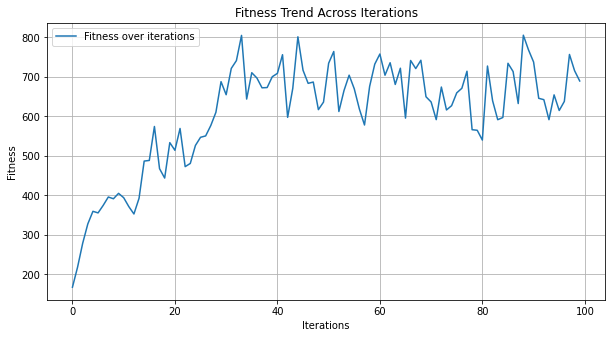

In [465]:
plt.figure(figsize=(10, 5))
plt.plot(cost_history_sum, label='Fitness over iterations')
plt.title('Fitness Trend Across Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()